In [1]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api = sj.Shioaji()

In [6]:
api.login('F128497445', 'j7629864')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [7]:
def getNearbyCode(td:datetime):
    month = getNearbyMonth(td)
    return [chr(m+65-1), chr(m+65-1+12)]
    
def getNearbyMonth(td: datetime = None):
    if not td:
        td = datetime.today()
    month = td.month
    if isTimetoMaturity(td): 
        month += 1
        if month > 12:
            month = 1
    return month

def getExistsContract(date: datetime, strikes:list, symbol:str='TXF', months:int=3) -> list:
    global call_code_map, put_code_map, opt_ticker_map
    opt_ticker = opt_ticker_map[symbol]
    Conti_Ms = getExistsContractMonth(date)
    contracts = []
    y = date.year
    next_y = y + 1
    for strike in strikes:
        strike = StrikeFill(strike, symbol)
        
        for m in Conti_Ms[:months]:
            call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(y)[-1]}'
            put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(y)[-1]}'
            if 12 in Conti_Ms[1:3]:
                if m < 12:
                    call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(next_y)[-1]}'
                    put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(next_y)[-1]}'
            contracts.extend([call_ticker, put_ticker])
    return contracts

def getExistsContractMonth(date):
    month = getNearbyMonth(date)
    conti_Ms = [x if x <= 12 else x - 12 for x in range(month, month + 3)]
    if conti_Ms[-1] in [3, 4, 5]: # 3個連續月份的最後一個月是3或4或5，判斷連續季月月份，以下雷同
        conti_Ms.extend([6, 9, 12])
    elif conti_Ms[-1] in [6, 7, 8]:
        conti_Ms.extend([9, 12, 3])
    elif conti_Ms[-1] in [9, 10, 11]:
        conti_Ms.extend([12, 3, 6])
    elif conti_Ms[-1] in [12, 1, 2]:
        conti_Ms.extend([3, 6, 9])
    return conti_Ms

def isTimetoMaturity(td):
    thirdWendesday = getThirdWendesday(td)
    if td.strftime('%Y%m%d') >= thirdWendesday.strftime('%Y%m%d'): 
        return True
    return False

def getThirdWendesday(td):
    week = 2
    first_wendesday = getFirstWendesday(td)
    return first_wendesday + timedelta(week * 7)

def getFirstWendesday(td):
    first_day = datetime(td.year, td.month, 2)
    if first_day.weekday() <= 2:
        adj_days = 2 - first_day.weekday()
    else:
        adj_days = 9 - first_day.weekday()
    return first_day + timedelta(adj_days)

def getContiCode(td:datetime):
    m = getNearbyMonth(td)
    next_m = (m + 1) % 12
    if not next_m:
        next_m = 12
    if m+1 > 12: 
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year + 1)[-1]]
    else:
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year)[-1]]
    

In [5]:
def GetPairData(api, date:datetime=datetime(2021,11,5)):
    
    dateStr = date.strftime("%Y-%m-%d")
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby2 = api.Contracts.Futures["MXF"+today_last_code[1]]
    
    contract_nearby.code = "MXF"+last_code[0]
    contract_nearby2.code = "MXF"+last_code[1]

    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())
    data_nearby2 = api.ticks(contract_nearby2, dateStr,
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())

    df_nearby = pd.DataFrame(data_nearby.dict())
    df_nearby2 = pd.DataFrame(data_nearby2.dict())

    df_nearby2['datetime'] = df_nearby2.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')))
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')))

    df_nearby = df_nearby.set_index('datetime')
    df_nearby2 = df_nearby2.set_index('datetime')

    indexes = list(set(list(df_nearby.index)).union(list(df_nearby2.index)))

    final_data = []
    for idx in sorted(indexes):#[:10]:
        nearby_1 = df_nearby.loc[:idx, :]
        try:
            nearby_1_CPrice = nearby_1.close[-1]
            nearby_1_bid = nearby_1.bid_price[-1]
            nearby_1_ask = nearby_1.ask_price[-1]
        except:
            nearby_1_CPrice = float('nan')
            nearby_1_bid = float('nan')
            nearby_1_ask = float('nan')
    
        nearby_2 = df_nearby2.loc[:idx, :]
        try:
            nearby_2_CPrice = nearby_2.close[-1]
            nearby_2_bid = nearby_2.bid_price[-1]
            nearby_2_ask = nearby_2.ask_price[-1]
        except:
            nearby_2_CPrice = float('nan')
            nearby_2_bid = float('nan')
            nearby_2_ask = float('nan')

        final_data.append(
        {
            'datetime':idx,
            'nearby1':nearby_1_CPrice,
            'nearby2':nearby_2_CPrice,
            'nearby1_ask':nearby_1_ask,
            'nearby1_bid':nearby_1_bid,
            'nearby2_ask':nearby_2_ask,
            'nearby2_bid':nearby_2_bid,

        })

    df=pd.DataFrame(final_data)
    if df.empty:return

    df['diff'] = df.nearby2 - df.nearby1
    estimateIdx = df.datetime.apply(lambda x: x.strftime("%H%M%S") <= '093000').index#df[,:].index
    df['diffMean'] = df.loc[estimateIdx,:]['diff'].mean()
    df['diffStd'] = df.loc[estimateIdx,:]['diff'].std()
    df['diffUpBand'] = df['diffMean'] + 1.5 * df['diffStd']
    df['diffDnBand'] = df['diffMean'] - 1.5 * df['diffStd']
    df['diff12'] = df.nearby1_bid - df.nearby2_ask
    df['diff21'] = df.nearby2_bid - df.nearby1_ask
    
    df['mean_diff12'] = df.loc[estimateIdx,:].diff12.mean()
    df['std_diff12'] = df.loc[estimateIdx,:].diff12.std()
    df['upband12'] = df['mean_diff12'] + 1.5 * df['std_diff12']
    df['dnband12'] = df['mean_diff12'] - 1.5 * df['std_diff12']

    df['mean_diff21'] = df.loc[estimateIdx,:].diff21.mean()
    df['std_diff21'] = df.loc[estimateIdx,:].diff21.std()
    df['upband21'] = df['mean_diff21'] + 1.5 * df['std_diff21']
    df['dnband21'] = df['mean_diff21'] - 1.5 * df['std_diff21']
    return df

In [78]:
df = GetPairData(api, dateStr='2021-10-27')

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: Mat

<AxesSubplot:label='9e868f1c-1817-4d9b-98ae-26797adce8a3'>

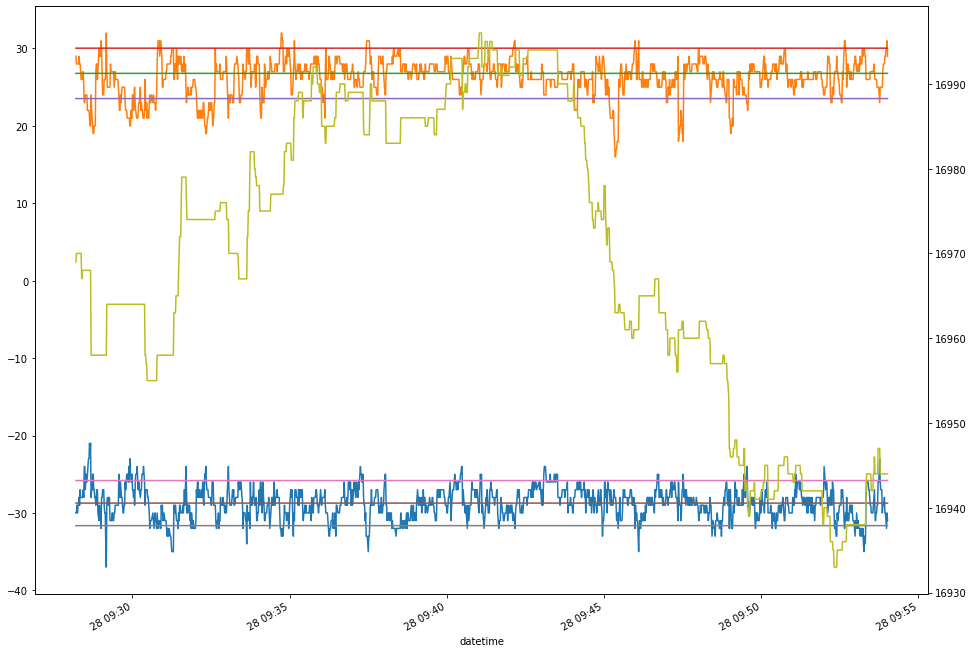

In [79]:
tmp_df = df.loc[df.index[2500]:df.index[4000],:].set_index('datetime')
# tmp_df = df.set_index('datetime')
tmp_df['diff'].plot(label='diff', figsize = (16,12))
tmp_df['diff12'].plot(label='diff12')#, figsize = (16,12))
tmp_df['mean_diff12'].plot(label='mu')
tmp_df['upband12'].plot(label='upband')
tmp_df['dnband12'].plot(label='dnband')
# tmp_df['diff21'].plot(label='diff21', figsize = (16,12))
# tmp_df['diffMean'].plot(label='diffMean', figsize = (16,12))
tmp_df['diffMean'].plot(label='diffmu')#, figsize = (16,12))
tmp_df['diffUpBand'].plot(label='diffUpBand')#, figsize = (16,12))
tmp_df['diffDnBand'].plot(label='diffDnBand')#, figsize = (16,12))
# tmp_df.nearby2.plot(label='nearby2')
tmp_df.nearby2.plot(label='nearby2', secondary_y=True)

In [80]:
df = GetPairData(api, dateStr='2021-11-01')

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: Mat

<AxesSubplot:label='8946c1c7-372f-4307-afc1-c2c0c2a09a04'>

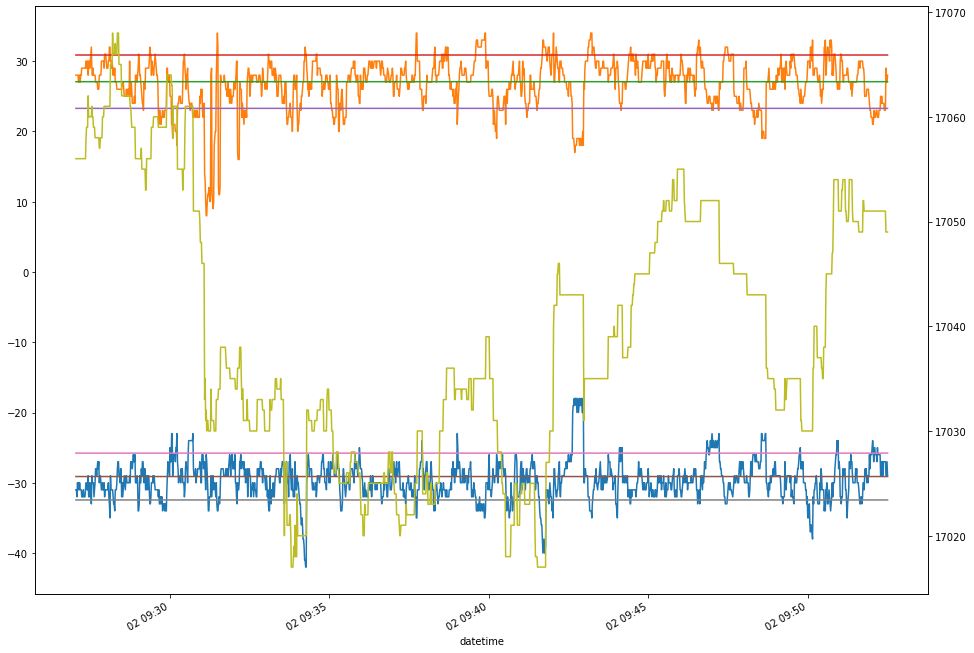

In [81]:
tmp_df = df.loc[df.index[2500]:df.index[4000],:].set_index('datetime')
# tmp_df = df.set_index('datetime')
tmp_df['diff'].plot(label='diff', figsize = (16,12))
tmp_df['diff12'].plot(label='diff12')#, figsize = (16,12))
tmp_df['mean_diff12'].plot(label='mu')
tmp_df['upband12'].plot(label='upband')
tmp_df['dnband12'].plot(label='dnband')
# tmp_df['diff21'].plot(label='diff21', figsize = (16,12))
# tmp_df['diffMean'].plot(label='diffMean', figsize = (16,12))
tmp_df['diffMean'].plot(label='diffmu')#, figsize = (16,12))
tmp_df['diffUpBand'].plot(label='diffUpBand')#, figsize = (16,12))
tmp_df['diffDnBand'].plot(label='diffDnBand')#, figsize = (16,12))
# tmp_df.nearby2.plot(label='nearby2')
tmp_df.nearby2.plot(label='nearby2', secondary_y=True)

In [12]:
def Backtest(df, takeprofit_reverse = 10, stoploss = 30, takeprofit_trend = 60, profit_enough=20, change_stop_loss=10):
    diff_12 = []
#     diff_21 = []
    diff = []
    mean_diff = 0
    std_diff = 0
    upband = 0
    dnband = 0
    mean_diff12 = 0
    std_diff12 = 0
    upband12 = 0
    dnband12 = 0
#     mean_diff21 = 0
#     std_diff21 = 0
#     upband21 = 0
#     dnband21 = 0

    setup_param = False
    entry = sig = pos = 0
    result = []
    total_pnl = 0
    total_win = 0
    total_loss = 0
    win_trade = 0
    loss_trade = 0
    record = {}
    end_Trade = False
    max_pnl = 0
    pnl_threshold = 30
    sig_multiplier = 1
    loss_num = 0
    max_unreal = 0
    tmp_sl = stoploss
    entry_abs_diff = 0
    tmp_abs_diff = 0
    for row in df.itertuples():
        if not np.isnan(row.diff12):
            diff_12.append(row.diff12)
#         diff_21.append(row.diff21)
        if not np.isnan(row.diff):
            diff.append(row.diff)
        if row.datetime.strftime("%H%M%S") <= '093000':continue
        if not setup_param:
            mean_diff12 = np.mean(diff_12)
            std_diff12 = np.std(diff_12)
            upband12 = mean_diff12 + 1.5 * std_diff12
            dnband12 = mean_diff12 - 1.5 * std_diff12
            
            mean_diff = np.mean(diff)
            std_diff = np.std(diff)
            upband = mean_diff + 1.5 * std_diff
            dnband = mean_diff - 1.5 * std_diff

#             mean_diff21 = np.mean(diff_21)
#             std_diff21 = np.std(diff_21)
#             upband21 = mean_diff21 + 1 * std_diff21
#             dnband21 = mean_diff21 - 1 * std_diff21
            setup_param = True
        if sig == 0 and pos == 0 and not end_Trade:
            if row.diff > upband:
#             if (mean_diff <= row.diff and row.diff <= upband) and (mean_diff12 <= row.diff12 and row.diff12 <= upband12):
#             if row.diff12 <= dnband12 and row.diff21 >= upband21:
                sig = -1 * sig_multiplier
#             elif (mean_diff12 <= row.diff12 and row.diff12 <= upband12) and (mean_diff <= row.diff and row.diff <= upband):
#             elif row.diff12 >= upband12 and row.diff21 <= dnband21:
            if row.diff < dnband:
                sig = 1 * sig_multiplier
#             elif row.diff21 >= upband:
#                 sig = 1
#             elif row.diff21 <= dnband:
#                 sig = -1
    #         print(f'sig : {sig}')
    #         print(f'upband12 : {upband12}, diff12 : {row.diff12}, dnband12 : {dnband12}')
    #         print(f'upband21 : {upband21}, diff21 : {row.diff21}, dnband21 : {dnband21}\n')
            if sig != 0 and pos == 0:
                if sig > 0:
                    entry  = row.nearby2_ask
                elif sig < 0:
                    entry  = row.nearby2_bid
                pos, sig = sig, 0
#                 entry_abs_diff = abs(row.diff - mean_diff)
                print(f'Entry : {entry}, pos : {pos} at ts : {row.datetime}, Close = {row.nearby2}')
        if sig == 0 and pos != 0:
#             tmp_abs_diff = abs(row.diff - mean_diff)
            if pos < 0:
                exit = row.nearby2_ask
            elif pos > 0:
                exit = row.nearby2_bid
            tmp_pnl = (exit - entry) * pos
    #         print(f'Exit : {exit}, unrealized pnl : {tmp_pnl}, total_pnl : {total_pnl} at ts : {row.datetime}\n')
#             max_unreal = max(max_unreal, tmp_pnl)
#             tmp_entry = entry + max_unreal * pos
#             moving_exit = tmp_entry - stoploss * pos
#             tmp_sl = stoploss - max_unreal
#             if max_unreal >= 5 and tmp_pnl <= max_unreal - change_stop_loss:
#                 sig =- pos
#             if tmp_abs_diff > entry_abs_diff:        
#                 if row.diff > upband and pos > 0:
#                     sig = -1 * sig_multiplier
#                 if row.diff < dnband and pos < 0:
#                     sig = 1 * sig_multiplier
#             if tmp_abs_diff > entry_abs_diff:
#                 sig = -pos
#             if (pos > 0 and exit < moving_exit) or (pos < 0 and exit > moving_exit):
#                 sig = -pos
            if (tmp_pnl >= takeprofit_reverse and sig_multiplier > 0) or (tmp_pnl >= takeprofit_trend and sig_multiplier < 0):
                sig = -pos
#                 if row.diff12 >= dnband12 and row.diff21 <= upband21:
#                     sig = -pos
#                 elif row.diff12 <= upband12 and row.diff21 >= dnband21:
#                     sig = -pos
#             elif tmp_pnl <= -tmp_sl:# or (total_pnl > pnl_threshold and tmp_pnl <= -min(total_pnl*0.1, stoploss)):
            elif tmp_pnl <= -stoploss:
                sig = -pos

            if sig != 0:
                pnl = (exit - entry) * pos
                total_pnl += pnl
                if pnl > 0:
                    win_trade += 1
                    total_win += pnl
                if pnl < 0:
                    loss_trade += 1
                    total_loss += pnl
                print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.datetime}, Close = {row.nearby2}\n')
                max_unreal = entry = exit = pos = sig = 0
                max_pnl = max(total_pnl, max_pnl)
            if (win_trade + loss_trade) > 0:
                if total_pnl < 0 and not loss_num:
                    loss_num = 1
                    sig_multiplier = -1
#                 elif tmp_pnl > 0 and sig_multiplier < 0:
#                     loss_num = 0
#                     sig_multiplier = 1
            
    #             if sig_multiplier < 0:
    #                 sig_multiplier = 1
#             if total_pnl <= -stoploss:
#                 end_Trade = True
            if (total_pnl <= -stoploss * 2) or total_pnl >= profit_enough:
                end_Trade = True
#             elif (win_trade + loss_trade) > 0 and max_pnl > 0:
#                 if max_pnl >= pnl_threshold:
#                     end_Trade = (row.datetime.strftime("%H%M%S") >= '134000') or (total_pnl / max_pnl <= 0.8)
            end_Trade = (row.datetime.strftime("%H%M%S") >= '134000') or end_Trade
                
        if row.datetime.strftime("%H%M%S") >= '134000':
            if pos != 0:
                if pos < 0:
                    exit  = row.nearby2_ask
                elif pos > 0:
                    exit  = row.nearby2_bid
                pnl = (exit - entry) * pos
                total_pnl += pnl
                if pnl > 0:
                    win_trade += 1
                    total_win += pnl
                if pnl < 0:
                    loss_trade += 1
                    total_loss += pnl
                print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.datetime}, Close = {row.nearby2}\n')
                entry = exit = pos = sig = 0
#                 total_pnl += pnl
                max_pnl = max(total_pnl, max_pnl)
            endTrade = True

    avg_win = total_win / win_trade if win_trade else 0
    avg_loss = total_loss / loss_trade if loss_trade else 0
    Q = avg_win / abs(avg_loss) if avg_loss else 0
    total_trade = win_trade + loss_trade
    Pw = win_trade / total_trade if total_trade else 0
    Ev = Q * Pw - (1 - Pw)
    Avg_PnL = total_pnl / total_trade if total_trade else 0
    print(f'Total PnL : {total_pnl}')
    print(f'Avg Win : {avg_win}')
    print(f'Num Win : {win_trade}')
    print(f'Avg Loss : {avg_loss}')
    print(f'Num Loss : {loss_trade}')
    print(f'Avg PnL : {Avg_PnL}')
    print(f'G/L : {Q}, Pw : {Pw}, Expected Value : {Ev}')
    print(f'Max Pnl : {max_pnl}\n')
    return (total_pnl, avg_win, win_trade, avg_loss, loss_trade, Avg_PnL, Q, Pw, Ev)

In [138]:
dateStr = "2021-10-27"#date.strftime("%Y-%m-%d")
df = GetPairData(api, dateStr=dateStr)
# if df is None:continue
print(dateStr)
results[dateStr] = Backtest(df)

2021-10-27
Entry : 16958.0, pos : -1 at ts : 2021-10-27 09:30:09+08:00
Exit : 16988.0, pnl : -30.0, total_pnl : -30.0 at ts : 2021-10-27 09:35:10+08:00

Entry : 16981.0, pos : -1 at ts : 2021-10-27 09:36:15+08:00
Exit : 16920.0, pnl : 61.0, total_pnl : 31.0 at ts : 2021-10-27 10:39:02+08:00

Entry : 16920.0, pos : 1 at ts : 2021-10-27 10:39:05+08:00
Exit : 16980.0, pnl : 60.0, total_pnl : 91.0 at ts : 2021-10-27 12:36:00+08:00

Total PnL : 91.0
Avg Win : 60.5
Num Win : 2
Avg Loss : -30.0
Num Loss : 1
Avg PnL : 30.333333333333332
G/L : 2.0166666666666666, Pw : 0.6666666666666666, Expected Value : 1.011111111111111

Max Pnl : 91.0


In [16]:
results = {}
for date in pd.date_range(datetime(2021,8,1), datetime(2021,11,5)):
#     dateStr = date.strftime("%Y-%m-%d")
    df = GetPairData(api, date=date)
    if df is None:continue
    print(date.strftime("%Y-%m-%d"))
    results[date] = Backtest(df)

2021-08-01
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0



c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2021-08-02
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0

2021-08-03
Entry : 17330.0, pos : -1 at ts : 2021-08-03 09:30:23+08:00, Close = 17336.0
Exit : 17320.0, pnl : 10.0, total_pnl : 10.0 at ts : 2021-08-03 09:33:19+08:00, Close = 17310.0

Entry : 17293.0, pos : -1 at ts : 2021-08-03 09:33:54+08:00, Close = 17298.0
Exit : 17282.0, pnl : 11.0, total_pnl : 21.0 at ts : 2021-08-03 10:02:31+08:00, Close = 17282.0

Total PnL : 21.0
Avg Win : 10.5
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 10.5
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 21.0

2021-08-04
Entry : 17422.0, pos : 1 at ts : 2021-08-04 09:30:01+08:00, Close = 17410.0
Exit : 17391.0, pnl : -31.0, total_pnl : -31.0 at ts : 2021-08-04 09:41:50+08:00, Close = 17391.0

Entry : 17381.0, pos : -1 at ts : 2021-08-04 09:41:55+08:00, Close = 17381.0
Exit : 17412.0, pnl : -31.0, total_pnl : -62.0 at ts : 2021-08-04 09:55:23+08:00, Close = 17412.0

T

Total PnL : -62.0
Avg Win : 0
Num Win : 0
Avg Loss : -31.0
Num Loss : 2
Avg PnL : -31.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0

2021-08-24
Entry : 16713.0, pos : 1 at ts : 2021-08-24 09:30:05+08:00, Close = 16713.0
Exit : 16723.0, pnl : 10.0, total_pnl : 10.0 at ts : 2021-08-24 09:35:17+08:00, Close = 16723.0

Entry : 16716.0, pos : -1 at ts : 2021-08-24 09:35:55+08:00, Close = 16736.0
Exit : 16706.0, pnl : 10.0, total_pnl : 20.0 at ts : 2021-08-24 09:41:08+08:00, Close = 16704.0

Total PnL : 20.0
Avg Win : 10.0
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 10.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 20.0

2021-08-25
Entry : 16800.0, pos : 1 at ts : 2021-08-25 09:30:24+08:00, Close = 16790.0
Exit : 16818.0, pnl : 18.0, total_pnl : 18.0 at ts : 2021-08-25 09:33:41+08:00, Close = 16819.0

Entry : 16786.0, pos : -1 at ts : 2021-08-25 09:34:02+08:00, Close = 16830.0
Exit : 16828.0, pnl : -42.0, total_pnl : -24.0 at ts : 2021-08-25 09:34:02+08:00, Close = 16830.

Total PnL : 45.0
Avg Win : 37.5
Num Win : 2
Avg Loss : -30.0
Num Loss : 1
Avg PnL : 15.0
G/L : 1.25, Pw : 0.6666666666666666, Expected Value : 0.4999999999999999
Max Pnl : 45.0

2021-09-13
Entry : 17315.0, pos : 1 at ts : 2021-09-13 09:30:01+08:00, Close = 17311.0
Exit : 17325.0, pnl : 10.0, total_pnl : 10.0 at ts : 2021-09-13 09:31:39+08:00, Close = 17326.0

Entry : 17331.0, pos : 1 at ts : 2021-09-13 09:31:54+08:00, Close = 17330.0
Exit : 17341.0, pnl : 10.0, total_pnl : 20.0 at ts : 2021-09-13 09:34:02+08:00, Close = 17344.0

Total PnL : 20.0
Avg Win : 10.0
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 10.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 20.0

2021-09-14
Entry : 17457.0, pos : -1 at ts : 2021-09-14 09:30:13+08:00, Close = 17459.0
Exit : 17447.0, pnl : 10.0, total_pnl : 10.0 at ts : 2021-09-14 09:42:29+08:00, Close = 17447.0

Entry : 17438.0, pos : -1 at ts : 2021-09-14 09:45:03+08:00, Close = 17440.0
Exit : 17428.0, pnl : 10.0, total_pnl : 20.0 at ts : 2021-09-1

Total PnL : 21.0
Avg Win : 10.5
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 10.5
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 21.0

2021-10-06
Entry : 16341.0, pos : 1 at ts : 2021-10-06 09:30:01+08:00, Close = 16336.0
Exit : 16353.0, pnl : 12.0, total_pnl : 12.0 at ts : 2021-10-06 09:31:28+08:00, Close = 16353.0

Entry : 16350.0, pos : -1 at ts : 2021-10-06 09:31:35+08:00, Close = 16353.0
Exit : 16338.0, pnl : 12.0, total_pnl : 24.0 at ts : 2021-10-06 09:35:34+08:00, Close = 16338.0

Total PnL : 24.0
Avg Win : 12.0
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 12.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 24.0

2021-10-07
Entry : 16609.0, pos : 1 at ts : 2021-10-07 09:30:14+08:00, Close = 16601.0
Exit : 16624.0, pnl : 15.0, total_pnl : 15.0 at ts : 2021-10-07 09:33:01+08:00, Close = 16633.0

Entry : 16633.0, pos : 1 at ts : 2021-10-07 09:33:03+08:00, Close = 16629.0
Exit : 16645.0, pnl : 12.0, total_pnl : 27.0 at ts : 2021-10-07 09:37:36+08:00, Close = 16646.0

Tot

Total PnL : 21.0
Avg Win : 10.5
Num Win : 2
Avg Loss : 0
Num Loss : 0
Avg PnL : 10.5
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 21.0

2021-10-27
Entry : 16958.0, pos : -1 at ts : 2021-10-27 09:30:09+08:00, Close = 16964.0
Exit : 16988.0, pnl : -30.0, total_pnl : -30.0 at ts : 2021-10-27 09:35:10+08:00, Close = 16988.0

Entry : 16981.0, pos : -1 at ts : 2021-10-27 09:36:15+08:00, Close = 16985.0
Exit : 16920.0, pnl : 61.0, total_pnl : 31.0 at ts : 2021-10-27 10:39:02+08:00, Close = 16912.0

Total PnL : 31.0
Avg Win : 61.0
Num Win : 1
Avg Loss : -30.0
Num Loss : 1
Avg PnL : 15.5
G/L : 2.033333333333333, Pw : 0.5, Expected Value : 0.5166666666666666
Max Pnl : 31.0

2021-10-28
Entry : 17040.0, pos : 1 at ts : 2021-10-28 09:30:05+08:00, Close = 17040.0
Exit : 17050.0, pnl : 10.0, total_pnl : 10.0 at ts : 2021-10-28 09:38:13+08:00, Close = 17050.0

Entry : 17063.0, pos : -1 at ts : 2021-10-28 09:38:25+08:00, Close = 17069.0
Exit : 17051.0, pnl : 12.0, total_pnl : 22.0 at ts : 2021-10-

In [17]:
cum_pnl = []
for d, res in results.items():
    print(d, res[0])
    if len(cum_pnl):
        cum_pnl.append(cum_pnl[-1] + res[0])
    else:
        cum_pnl.append(res[0])

2021-08-01 00:00:00 0
2021-08-02 00:00:00 0
2021-08-03 00:00:00 21.0
2021-08-04 00:00:00 -62.0
2021-08-05 00:00:00 -35.0
2021-08-06 00:00:00 -62.0
2021-08-09 00:00:00 30.0
2021-08-10 00:00:00 23.0
2021-08-11 00:00:00 20.0
2021-08-12 00:00:00 20.0
2021-08-13 00:00:00 -60.0
2021-08-16 00:00:00 41.0
2021-08-17 00:00:00 -82.0
2021-08-18 00:00:00 24.0
2021-08-19 00:00:00 21.0
2021-08-20 00:00:00 22.0
2021-08-23 00:00:00 -62.0
2021-08-24 00:00:00 20.0
2021-08-25 00:00:00 -69.0
2021-08-26 00:00:00 -60.0
2021-08-27 00:00:00 23.0
2021-08-30 00:00:00 34.0
2021-08-31 00:00:00 -85.0
2021-09-01 00:00:00 -62.0
2021-09-02 00:00:00 -82.0
2021-09-03 00:00:00 35.0
2021-09-06 00:00:00 -61.0
2021-09-07 00:00:00 -62.0
2021-09-08 00:00:00 -60.0
2021-09-09 00:00:00 -61.0
2021-09-10 00:00:00 45.0
2021-09-13 00:00:00 20.0
2021-09-14 00:00:00 20.0
2021-09-15 00:00:00 24.0
2021-09-16 00:00:00 0
2021-09-17 00:00:00 0
2021-09-22 00:00:00 -61.0
2021-09-23 00:00:00 -66.0
2021-09-24 00:00:00 -86.0
2021-09-27 00:00:00

In [18]:
cum_pnl

[0,
 0,
 21.0,
 -41.0,
 -76.0,
 -138.0,
 -108.0,
 -85.0,
 -65.0,
 -45.0,
 -105.0,
 -64.0,
 -146.0,
 -122.0,
 -101.0,
 -79.0,
 -141.0,
 -121.0,
 -190.0,
 -250.0,
 -227.0,
 -193.0,
 -278.0,
 -340.0,
 -422.0,
 -387.0,
 -448.0,
 -510.0,
 -570.0,
 -631.0,
 -586.0,
 -566.0,
 -546.0,
 -522.0,
 -522.0,
 -522.0,
 -583.0,
 -649.0,
 -735.0,
 -709.0,
 -684.0,
 -746.0,
 -726.0,
 -814.0,
 -788.0,
 -767.0,
 -743.0,
 -716.0,
 -790.0,
 -852.0,
 -912.0,
 -871.0,
 -932.0,
 -887.0,
 -947.0,
 -1019.0,
 -989.0,
 -958.0,
 -930.0,
 -909.0,
 -878.0,
 -856.0,
 -817.0,
 -868.0,
 -940.0,
 -920.0,
 -897.0,
 -874.0]